In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import shutil
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, RandomHorizontalFlip, RandomRotation, ColorJitter, GaussianBlur
from torch.utils.data.dataloader import DataLoader, Dataset
from torch.utils.data import random_split
import torch.nn as nn
import torchvision.models as models
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import seaborn as sns

In [2]:
# Define the path to the image folder
path = './cropped(0-1199)/'
output_path = './ABCD/'
behaviors = ['running/', 'standing/', 'walking/']

# Check whether the folder already exist or not
# If not, proceed to make directories of the following categories
if not os.path.exists(output_path+behaviors[0]):
    os.makedirs(output_path+behaviors[0])
if not os.path.exists(output_path+behaviors[1]):
    os.makedirs(output_path+behaviors[1])
if not os.path.exists(output_path+behaviors[2]):
    os.makedirs(output_path+behaviors[2])

In [3]:
running_path = path+behaviors[0]
standing_path = path+behaviors[1]
walking_path = path+behaviors[2]

running_dir = os.listdir(running_path)
standing_dir = os.listdir(standing_path)
walking_dir = os.listdir(walking_path)

chunk_size = 4
image_chunks_running = [running_dir[i:i+chunk_size] for i in range(0, len(running_dir), chunk_size)]
image_chunks_standing = [standing_dir[i:i+chunk_size] for i in range(0, len(standing_dir), chunk_size)]
image_chunks_walking = [walking_dir[i:i+chunk_size] for i in range(0, len(walking_dir), chunk_size)]

stacked_images_running = []
stacked_images_standing = []
stacked_images_walking = []

for chunk in image_chunks_running:
    images = []

    for file_path in chunk:
        image = cv2.imread(running_path+file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images.append(image)

    stacked_image = np.stack(images, axis=-1)
    stacked_images_running.append(stacked_image)

for chunk in image_chunks_standing:
    images = []
    
    for file_path in chunk:
        image = cv2.imread(standing_path+file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images.append(image)

    stacked_image = np.stack(images, axis=-1)
    stacked_images_standing.append(stacked_image)

for chunk in image_chunks_walking:
    images = []
    
    for file_path in chunk:
        image = cv2.imread(walking_path+file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images.append(image)

    stacked_image = np.stack(images, axis=-1)
    stacked_images_walking.append(stacked_image)

# for i, stacked_images in enumerate(stacked_images_running):
#     output_file = f'{i+1}.png'
#     cv2.imwrite(output_path+behaviors[0]+output_file, stacked_images)

# for i, stacked_images in enumerate(stacked_images_standing):
#     output_file = f'{i+1}.png'
#     cv2.imwrite(output_path+behaviors[1]+output_file, stacked_images)

# for i, stacked_images in enumerate(stacked_images_walking):
#     output_file = f'{i+1}.png'
#     cv2.imwrite(output_path+behaviors[2]+output_file, stacked_images)

stacked_images_running = np.array(stacked_images_running, dtype=object)
stacked_images_standing = np.array(stacked_images_standing, dtype=object)
stacked_images_walking = np.array(stacked_images_walking, dtype=object)

np.save('running.npy', stacked_images_running)
np.save('standing.npy', stacked_images_standing)
np.save('walking.npy', stacked_images_walking)

In [4]:
print(stacked_images_running[0].shape)
print(stacked_images_standing[0].shape)
print(stacked_images_walking[0].shape)

(137, 106, 4)
(157, 160, 4)
(160, 89, 4)


In [5]:
class CustomDataset(Dataset):

    def __init__(self, file_paths, labels, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform

        for file_path, label in zip(file_paths, labels):
            loaded_data = np.load(file_path, allow_pickle=True)
            for item in loaded_data:
                self.data.append(item)
                self.labels.append(label)

        self.data = np.array(self.data)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        
        if self.transform:
            x = self.transform(x)

        x = self.normalize(x)

        return torch.Tensor(x), y
    
    def normalize(self, x):
        # Assuming x is a 4-channel grayscale image (150, 150, 4)
        # Normalize each channel independently
        for channel in range(4):
            channel_data = x[channel, :, :]
            # Perform normalization, e.g., using mean and standard deviation
            mean = channel_data.mean()
            std = channel_data.std()
            x[channel, :, :] = (channel_data - mean) / std

        return x

In [6]:
transform_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((150, 150)),
    GaussianBlur(kernel_size=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
])

In [7]:
file_paths = ['running.npy', 'standing.npy', 'walking.npy']
labels = [0, 1, 2]
dataset = CustomDataset(file_paths, labels, transform=transform_aug)

C:\Users\is0593xr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [8]:
first_data_point, first_label = dataset[0]
last_data_point, last_label = dataset[-1]
print(first_data_point.shape, first_label)
print(last_data_point.shape, last_label)

torch.Size([4, 150, 150]) 0
torch.Size([4, 150, 150]) 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 150, 150])


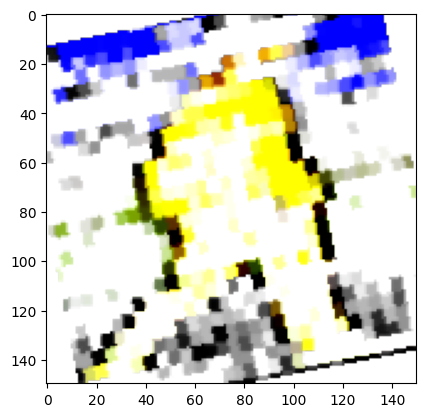

In [9]:
from torchvision.utils import make_grid

# Get one image from the dataset
img, label = dataset[-1]

# Convert the image tensor to a grid format
img_grid = make_grid(img.unsqueeze(0))
print(img_grid.shape)
# Display the image
plt.imshow(img_grid.permute(1, 2, 0))
plt.show()

In [10]:
print(img.shape)
img[3,:,:]


torch.Size([4, 150, 150])


tensor([[-1.8379, -1.8379, -1.8379,  ..., -1.8379, -1.8379, -1.8379],
        [-1.8379, -1.8379, -1.8379,  ..., -1.8379, -1.8379, -1.8379],
        [-1.8379, -1.8379, -1.8379,  ..., -1.8379, -1.8379, -1.8379],
        ...,
        [-1.8379, -1.8379, -1.8379,  ..., -1.8379, -1.8379, -1.8379],
        [-1.8379, -1.8379, -1.8379,  ..., -1.8379, -1.8379, -1.8379],
        [-1.8379, -1.8379, -1.8379,  ..., -1.8379, -1.8379, -1.8379]])

In [11]:
# Split dataset to three: training (70%), validation (15%) and testing datasets (15%)
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.7, 0.15, 0.15])

batch_size = 128 # Set the batch size to 128

# Load the datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


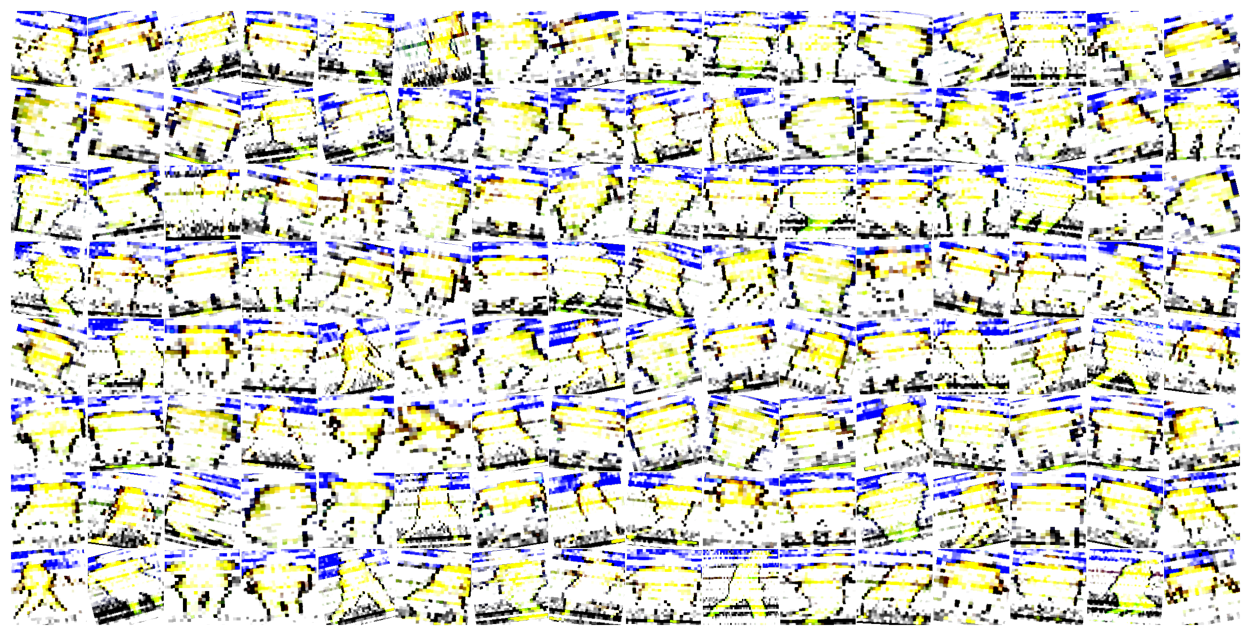

In [12]:
for images, _ in train_loader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [13]:
# Load the pre-trained model
model = models.resnet18()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
class_num = 3 # Since there are three categories of images, we set the number of class to 3

# Modify the first convolutional layer to accept 4 channels
model.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Change the last layer to match the number of classes in your dataset
num_ftrs = model.fc.in_features # Take the number of inputs for the linear layer
model.fc = nn.Linear(num_ftrs, class_num) # change the output layer size to 3

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss() # Loss function using Cross Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # Optimizer using Adam optimizer, with learning rate set to 0.0001

num_epochs = 50 # Number of epochs

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Create lists to store the accuracy and loss of training and validation values
train_acc_values = [] # List of training accuracy
train_loss_values = [] # List of training loss
val_acc_values = [] # List of validation accuracy
val_loss_values = [] # List of validation loss

# Train the model
# Iterates over a specified number of epochs.
for epoch in range(num_epochs):
    # Initialize the running loss, running corrects, and total
    running_loss = 0.0
    running_corrects = 0
    total = 0
    # Use tqdm to display the progress bar
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
        for inputs, labels in train_loader: # Iterate over the training dataset
            # Move the inputs and labels to the GPU
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.int64)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs) # Compute the model's predictions/output
            loss = criterion(outputs, labels) # Calculate the loss using the criterion function, which compares the predictions to the true labels
            _, predicted = torch.max(outputs.data, 1) # Obtain the index of the max element in each row of the output tensor using the function torch.max() function to give the predicted class of each input
            running_loss += loss.item() * inputs.size(0) # The running loss is updated by adding the loss of the current batch and multiplied by the number of samples in the batch
            running_corrects += (predicted == labels).sum().item() # The running corrects is updated by adding the number of correct predictions in the current batch
            total += labels.size(0) # Track the total number of samples processed so far

            # Backward pass and optimization
            loss.backward() # Compute the gradients of the model's parameters using the loss function
            optimizer.step() # Optimize the model's parameters

            # Update the progress bar
            pbar.update(1) 
            pbar.set_postfix(loss=running_loss / total, acc=running_corrects / total) # Display the current loss and accuracy
    
    # Append the accuracy and loss values to the lists
    train_acc_values.append(running_corrects / total)
    train_loss_values.append(running_loss / total)

    # Validation step at the end of each epoch
    model.eval() # set the model to evaluation mode 
    with torch.no_grad(): # Prevent PyTorch from tracking the gradients while validation to save computational power and time
        # Initialize the running loss, running corrects, and total for validation
        val_running_loss = 0.0
        val_running_corrects = 0
        val_total = 0

        for inputs, labels in val_loader: # Iterate over the validation dataset
            # Move the inputs and labels to the GPU
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.int64)

            # Forward pass
            # Similar step as the training process
            outputs = model(inputs) # Compute the model's predictions/output
            loss = criterion(outputs, labels) # Calculate the loss using the criterion function
            _, predicted = torch.max(outputs.data, 1) # Get the predicted value from the index of the max element in each row of the output tensor
            val_running_loss += loss.item() * inputs.size(0) # Update the validation running loss
            val_running_corrects += (predicted == labels).sum().item() # Update the validation running corrects
            val_total += labels.size(0) # Track the total number of samples processed so far
    
    # Calculate validation accuracy and loss
    val_acc = val_running_corrects / val_total
    val_loss = val_running_loss / val_total
    print(f'val_acc: {val_acc}, val_loss: {val_loss}') # Display the validation accuracy and loss

    # Append the value of validation accuracy and loss to list
    val_acc_values.append(val_acc)
    val_loss_values.append(val_loss)

Epoch 1/50: 100%|██████████| 20/20 [00:12<00:00,  1.64batch/s, acc=0.611, loss=0.847]


val_acc: 0.6296296296296297, val_loss: 0.9095226596902918


Epoch 2/50: 100%|██████████| 20/20 [00:09<00:00,  2.01batch/s, acc=0.609, loss=0.895]


val_acc: 0.662962962962963, val_loss: 0.7056771185663011


Epoch 3/50: 100%|██████████| 20/20 [00:10<00:00,  2.00batch/s, acc=0.758, loss=0.55] 


val_acc: 0.7685185185185185, val_loss: 0.4760110570324792


Epoch 4/50: 100%|██████████| 20/20 [00:10<00:00,  2.00batch/s, acc=0.806, loss=0.446]


val_acc: 0.7703703703703704, val_loss: 0.4929284190690076


Epoch 5/50: 100%|██████████| 20/20 [00:10<00:00,  1.99batch/s, acc=0.821, loss=0.404]


val_acc: 0.8037037037037037, val_loss: 0.419486630625195


Epoch 6/50: 100%|██████████| 20/20 [00:10<00:00,  1.99batch/s, acc=0.858, loss=0.332]


val_acc: 0.7962962962962963, val_loss: 0.46903252082842367


Epoch 7/50: 100%|██████████| 20/20 [00:10<00:00,  1.98batch/s, acc=0.793, loss=0.482]


val_acc: 0.7018518518518518, val_loss: 0.6202857161009753


Epoch 8/50: 100%|██████████| 20/20 [00:09<00:00,  2.02batch/s, acc=0.801, loss=0.43] 


val_acc: 0.8240740740740741, val_loss: 0.3590601041361138


Epoch 9/50: 100%|██████████| 20/20 [00:09<00:00,  2.02batch/s, acc=0.862, loss=0.315]


val_acc: 0.8481481481481481, val_loss: 0.33986428026799803


Epoch 10/50: 100%|██████████| 20/20 [00:10<00:00,  1.99batch/s, acc=0.883, loss=0.28] 


val_acc: 0.8518518518518519, val_loss: 0.3568513271985231


Epoch 11/50: 100%|██████████| 20/20 [00:09<00:00,  2.01batch/s, acc=0.877, loss=0.28] 


val_acc: 0.8870370370370371, val_loss: 0.2969608353243934


Epoch 12/50: 100%|██████████| 20/20 [00:10<00:00,  2.00batch/s, acc=0.89, loss=0.254] 


val_acc: 0.8722222222222222, val_loss: 0.29867275180640046


Epoch 13/50: 100%|██████████| 20/20 [00:09<00:00,  2.00batch/s, acc=0.906, loss=0.228]


val_acc: 0.8555555555555555, val_loss: 0.3599263036692584


Epoch 14/50: 100%|██████████| 20/20 [00:09<00:00,  2.02batch/s, acc=0.892, loss=0.252]


val_acc: 0.8777777777777778, val_loss: 0.29002503620253667


Epoch 15/50: 100%|██████████| 20/20 [00:09<00:00,  2.02batch/s, acc=0.896, loss=0.25] 


val_acc: 0.8759259259259259, val_loss: 0.28200208357086887


Epoch 16/50: 100%|██████████| 20/20 [00:09<00:00,  2.02batch/s, acc=0.915, loss=0.197]


val_acc: 0.8962962962962963, val_loss: 0.24809857573774124


Epoch 17/50: 100%|██████████| 20/20 [00:09<00:00,  2.01batch/s, acc=0.918, loss=0.209]


val_acc: 0.8759259259259259, val_loss: 0.29064925070162173


Epoch 18/50: 100%|██████████| 20/20 [00:09<00:00,  2.02batch/s, acc=0.924, loss=0.183]


val_acc: 0.9092592592592592, val_loss: 0.22682962483829922


Epoch 19/50: 100%|██████████| 20/20 [00:09<00:00,  2.01batch/s, acc=0.914, loss=0.205]


val_acc: 0.9148148148148149, val_loss: 0.21229930012314407


Epoch 20/50: 100%|██████████| 20/20 [00:09<00:00,  2.02batch/s, acc=0.931, loss=0.175]


val_acc: 0.8574074074074074, val_loss: 0.37550223845022696


Epoch 21/50: 100%|██████████| 20/20 [00:09<00:00,  2.01batch/s, acc=0.938, loss=0.16] 


val_acc: 0.9296296296296296, val_loss: 0.1775344009200732


Epoch 22/50: 100%|██████████| 20/20 [00:10<00:00,  2.00batch/s, acc=0.952, loss=0.127]


val_acc: 0.9, val_loss: 0.2614565158331836


Epoch 23/50: 100%|██████████| 20/20 [00:09<00:00,  2.01batch/s, acc=0.937, loss=0.15] 


val_acc: 0.9148148148148149, val_loss: 0.2384782009654575


Epoch 24/50: 100%|██████████| 20/20 [00:10<00:00,  1.99batch/s, acc=0.938, loss=0.15] 


val_acc: 0.9185185185185185, val_loss: 0.17861855857902104


Epoch 25/50: 100%|██████████| 20/20 [00:09<00:00,  2.00batch/s, acc=0.959, loss=0.108]


val_acc: 0.9203703703703704, val_loss: 0.1906012208097511


Epoch 26/50: 100%|██████████| 20/20 [00:09<00:00,  2.03batch/s, acc=0.965, loss=0.0894]


val_acc: 0.937037037037037, val_loss: 0.16915700987533286


Epoch 27/50: 100%|██████████| 20/20 [00:09<00:00,  2.01batch/s, acc=0.933, loss=0.162]


val_acc: 0.8962962962962963, val_loss: 0.2529160165676364


Epoch 28/50: 100%|██████████| 20/20 [00:10<00:00,  2.00batch/s, acc=0.931, loss=0.167]


val_acc: 0.9222222222222223, val_loss: 0.19305895191651803


Epoch 29/50: 100%|██████████| 20/20 [00:10<00:00,  1.99batch/s, acc=0.969, loss=0.0883]


val_acc: 0.9203703703703704, val_loss: 0.22777883349745362


Epoch 30/50: 100%|██████████| 20/20 [00:09<00:00,  2.02batch/s, acc=0.963, loss=0.092] 


val_acc: 0.937037037037037, val_loss: 0.13881957365406883


Epoch 31/50: 100%|██████████| 20/20 [00:09<00:00,  2.01batch/s, acc=0.969, loss=0.0778]


val_acc: 0.9296296296296296, val_loss: 0.16219279606033254


Epoch 32/50: 100%|██████████| 20/20 [00:10<00:00,  1.98batch/s, acc=0.962, loss=0.0913]


val_acc: 0.8962962962962963, val_loss: 0.2564508275853263


Epoch 33/50: 100%|██████████| 20/20 [00:10<00:00,  2.00batch/s, acc=0.973, loss=0.0712]


val_acc: 0.937037037037037, val_loss: 0.1448717607392205


Epoch 34/50: 100%|██████████| 20/20 [00:09<00:00,  2.01batch/s, acc=0.978, loss=0.0609]


val_acc: 0.9074074074074074, val_loss: 0.294004889384464


Epoch 35/50: 100%|██████████| 20/20 [00:09<00:00,  2.01batch/s, acc=0.956, loss=0.119]


val_acc: 0.9444444444444444, val_loss: 0.1325156671581445


Epoch 36/50: 100%|██████████| 20/20 [00:10<00:00,  1.98batch/s, acc=0.978, loss=0.0652]


val_acc: 0.9537037037037037, val_loss: 0.1591068191660775


Epoch 37/50: 100%|██████████| 20/20 [00:09<00:00,  2.00batch/s, acc=0.981, loss=0.0587]


val_acc: 0.9351851851851852, val_loss: 0.1943338789873653


Epoch 38/50: 100%|██████████| 20/20 [00:09<00:00,  2.00batch/s, acc=0.984, loss=0.036] 


val_acc: 0.95, val_loss: 0.1376133683654997


Epoch 39/50: 100%|██████████| 20/20 [00:10<00:00,  1.99batch/s, acc=0.986, loss=0.0423]


val_acc: 0.9351851851851852, val_loss: 0.17333004353223025


Epoch 40/50: 100%|██████████| 20/20 [00:10<00:00,  1.98batch/s, acc=0.982, loss=0.0488]


val_acc: 0.9259259259259259, val_loss: 0.18295588625801934


Epoch 41/50: 100%|██████████| 20/20 [00:09<00:00,  2.01batch/s, acc=0.978, loss=0.0579]


val_acc: 0.9666666666666667, val_loss: 0.09902101636484817


Epoch 42/50: 100%|██████████| 20/20 [00:09<00:00,  2.01batch/s, acc=0.987, loss=0.0419]


val_acc: 0.9425925925925925, val_loss: 0.1289552215072844


Epoch 43/50: 100%|██████████| 20/20 [00:10<00:00,  1.99batch/s, acc=0.985, loss=0.0352]


val_acc: 0.9333333333333333, val_loss: 0.23772454159679235


Epoch 44/50: 100%|██████████| 20/20 [00:10<00:00,  2.00batch/s, acc=0.981, loss=0.0496]


val_acc: 0.9518518518518518, val_loss: 0.1564701125577644


Epoch 45/50: 100%|██████████| 20/20 [00:10<00:00,  1.97batch/s, acc=0.985, loss=0.0449]


val_acc: 0.9648148148148148, val_loss: 0.11500950119009724


Epoch 46/50: 100%|██████████| 20/20 [00:09<00:00,  2.01batch/s, acc=0.983, loss=0.0466]


val_acc: 0.9462962962962963, val_loss: 0.14227807295543177


Epoch 47/50: 100%|██████████| 20/20 [00:10<00:00,  1.97batch/s, acc=0.981, loss=0.0454]


val_acc: 0.9555555555555556, val_loss: 0.15974822684570594


Epoch 48/50: 100%|██████████| 20/20 [00:09<00:00,  2.03batch/s, acc=0.989, loss=0.0327]


val_acc: 0.9481481481481482, val_loss: 0.13942329603833734


Epoch 49/50: 100%|██████████| 20/20 [00:10<00:00,  2.00batch/s, acc=0.984, loss=0.0372]


val_acc: 0.95, val_loss: 0.13166446851359473


Epoch 50/50: 100%|██████████| 20/20 [00:10<00:00,  2.00batch/s, acc=0.987, loss=0.0295]


val_acc: 0.8907407407407407, val_loss: 0.31958005729096906


In [15]:
# Test the model
model.eval() # Set the model to evaluation mode
with torch.no_grad(): # Prevent gradients tracking
    # Initialize the number of correct predictions, total number of predictions, running loss, y_true and y_pred
    correct = 0 
    total = 0
    running_loss = 0
    y_true = []
    y_pred = []
    
    # This part is the same as validation process but using training data instead 
    for inputs, labels in tqdm(test_loader, desc="Testing", unit="batch"): # Iterate over the training dataset
        # Move the inputs and labels to the GPU (if the computer has GPU)
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.int64)

        # Forward pass
        outputs = model(inputs) # Compute the model's predictions/output
        loss = criterion(outputs, labels) # Calculate the loss using the criterion function
        _, predicted = torch.max(outputs.data, 1) # Get the predicted value from the index of the max element in each row of the output tensor
        correct += (predicted == labels).sum().item() # Update the correct prediction
        total += labels.size(0) # Track the total number of samples processed so far
        running_loss += loss.item() * inputs.size(0) # Update the testing running loss
        y_true.extend(labels.cpu().numpy()) # Append true labels to the list
        y_pred.extend(predicted.cpu().numpy()) # Append predicted labels to the list
        
    test_accuracy = correct / total # Compute the test accuracy by dividing the number of correct predictions by the total number of predictions

Testing: 100%|██████████| 5/5 [00:02<00:00,  2.09batch/s]


In [16]:
# Generate classification report
class_names = ['running', 'standing', 'walking'] # List of class names

print(f'Accuracy of the model on the test images: {test_accuracy*100:.2f}%') # Print the accuracy percentage of the model on the test image
print(classification_report(y_true, y_pred, target_names=class_names)) # Show the classification report based on the true and predicted labels, and replace the classes name with the above list

Accuracy of the model on the test images: 90.00%
              precision    recall  f1-score   support

     running       0.78      0.98      0.87       165
    standing       0.98      0.99      0.99       187
     walking       0.97      0.74      0.84       188

    accuracy                           0.90       540
   macro avg       0.91      0.90      0.90       540
weighted avg       0.92      0.90      0.90       540



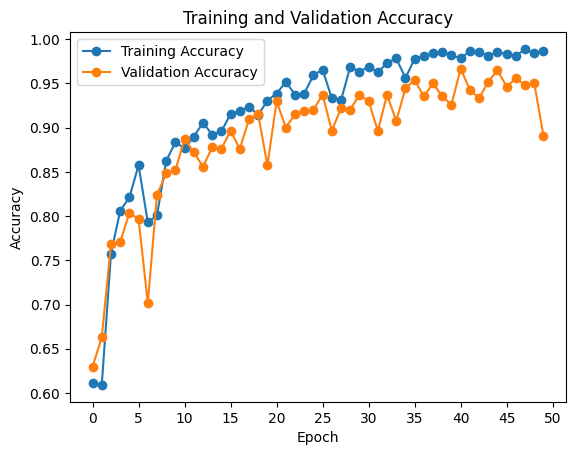

In [17]:
# Plot the training and validation accuracy
plt.figure() # Create a new figure
plt.title("Training and Validation Accuracy") # Set title
plt.plot(train_acc_values, '-o', label='Training Accuracy') # Plot the training accuracy values
plt.plot(val_acc_values, '-o', label='Validation Accuracy') # Plot the validation accuracy values
plt.xticks(np.arange(0, num_epochs+1, 5)) # Set the x-axis ticks every 5 steps
plt.xlabel('Epoch') # Set the x-axis label
plt.ylabel('Accuracy') # Set the y-axis label
plt.legend() # Show legend
plt.show() # Display the plot

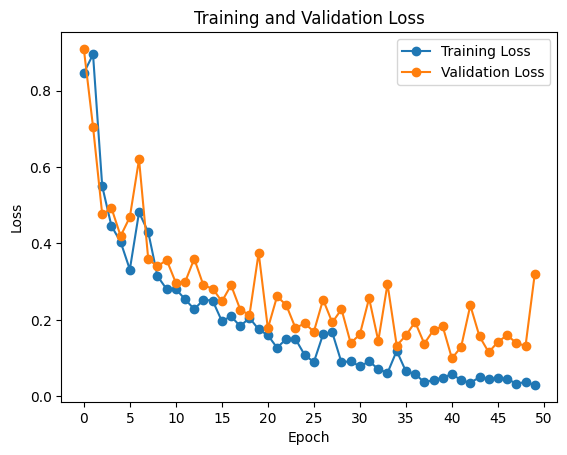

In [18]:
# Plot the training and validation loss
plt.figure() # Create a new figure
plt.title("Training and Validation Loss") # Set title
plt.plot(train_loss_values, '-o', label='Training Loss') # Plot the training loss values
plt.plot(val_loss_values, '-o', label='Validation Loss') # Plot the validation loss values
plt.xticks(np.arange(0, num_epochs+1, 5)) # Set the x-axis ticks every 5 steps
plt.xlabel('Epoch') # Set the x-axis label
plt.ylabel('Loss') # Set the y-axis label
plt.legend() # Show legend
plt.show() # Display the plot

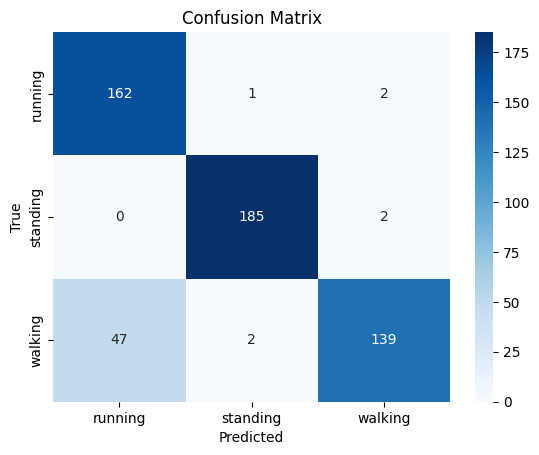

In [19]:
# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix using seaborn
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted') # Set the x-axis label
plt.ylabel('True') # Set the y-axis label
plt.title('Confusion Matrix') # Set the title
plt.show() # Show the plot

In [20]:
print(model)

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
# torch.save(model.state_dict(), 'trained_models/resnet18_model.pth')